In [1]:
import tensorflow as tf
import keras_preprocessing
from tensorflow.keras.utils import load_img, img_to_array
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
import PIL
from PIL import Image
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cv2
import sys

In [2]:
IMG_SIZE = (160, 160)

TRAIN_DIR = "C:/Users/charr/Desktop/RealTimeObjectDetection-main/RealTimeObjectDetection-main/Tensorflow/workspace/images/train"
train_dataset = tf.keras.utils.image_dataset_from_directory(TRAIN_DIR,
                                                       image_size = IMG_SIZE, batch_size = 40)

VALIDATION_DIR = "C:/Users/charr/Desktop/RealTimeObjectDetection-main/RealTimeObjectDetection-main/Tensorflow/workspace/images/test"
validation_dataset = tf.keras.utils.image_dataset_from_directory(VALIDATION_DIR,
                                                       image_size = IMG_SIZE, batch_size = 20)

Found 10000 files belonging to 2 classes.
Found 1458 files belonging to 2 classes.


In [3]:
class_names = train_dataset.class_names
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 59
Number of test batches: 14


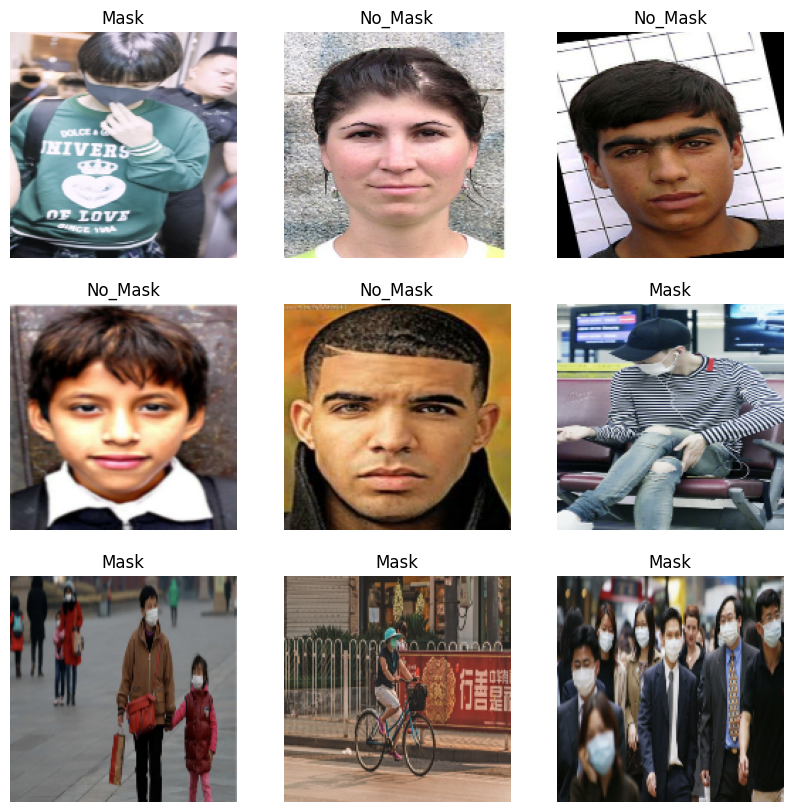

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [6]:
data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'), tf.keras.layers.RandomRotation(0.2),])

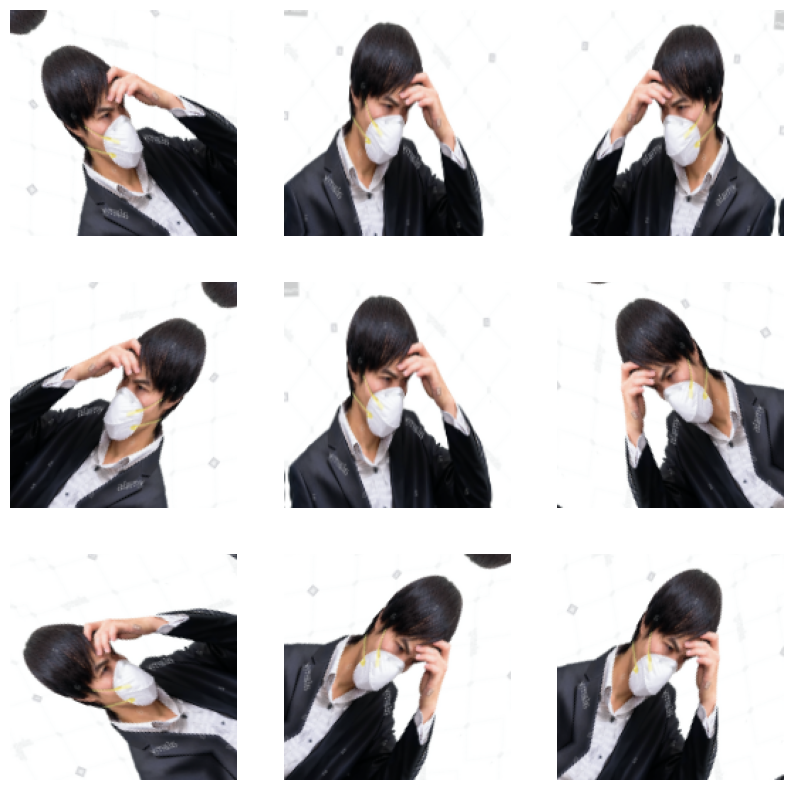

In [7]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [8]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(40, 5, 5, 1280)


In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 20, 20, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_depthwise_relu (ReLU)  (None, 20, 20, 144)  0           ['block_3_depthwise_BN[0][0]']   
                                                                                                  
 block_3_project (Conv2D)       (None, 20, 20, 32)   4608        ['block_3_depthwise_relu[0][0]'] 
                                                                                                  
 block_3_project_BN (BatchNorma  (None, 20, 20, 32)  128         ['block_3_project[0][0]']        
 lization)

 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 10, 10, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 10, 10, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)                                                                                            
                                                                                                  
 block_7_depthwise_BN (BatchNor  (None, 10, 10, 384)  1536       ['block_7_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_7_d

 block_10_project_BN (BatchNorm  (None, 10, 10, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 10, 10, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_expand_BN (BatchNorma  (None, 10, 10, 576)  2304       ['block_11_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_11_expand_relu (ReLU)    (None, 10, 10, 576)  0           ['block_11_expand_BN[0][0]']     
                                                                                                  
 block_11_

                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 5, 5, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 5, 5, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_project_BN (BatchNorm  (None, 5, 5, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 5, 5, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
          

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(40, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(40, 1)


In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [29]:
initial_epochs = 75

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

400/400 [==============================] - 98s 243ms/step - loss: 0.7241 - accuracy: 0.9011
initial loss: 0.72
initial accuracy: 0.90


In [30]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/75
37/37 [==============================] - 119s 3s/step - loss: 2.1498e-04 - accuracy: 1.0000 - val_loss: 0.8188 - val_accuracy: 0.8936
Epoch 2/75
37/37 [==============================] - 119s 3s/step - loss: 6.5055e-05 - accuracy: 1.0000 - val_loss: 0.7171 - val_accuracy: 0.9032
Epoch 3/75
37/37 [==============================] - 116s 3s/step - loss: 9.7389e-05 - accuracy: 1.0000 - val_loss: 0.6938 - val_accuracy: 0.9091
Epoch 4/75
37/37 [==============================] - 117s 3s/step - loss: 8.5941e-04 - accuracy: 0.9993 - val_loss: 0.7388 - val_accuracy: 0.9009
Epoch 5/75
37/37 [==============================] - 121s 3s/step - loss: 4.1590e-05 - accuracy: 1.0000 - val_loss: 0.7678 - val_accuracy: 0.8997
Epoch 6/75
37/37 [==============================] - 120s 3s/step - loss: 5.9681e-05 - accuracy: 1.0000 - val_loss: 0.7139 - val_accuracy: 0.9086
Epoch 7/75
37/37 [==============================] - 121s 3s/step - loss: 2.5344e-05 - accuracy: 1.0000 - val_loss: 0.7310 - val_ac

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


In [32]:
base_model.trainable = True

In [33]:
# Number of layers in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [36]:
fine_tune_epochs = 70
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 75/145
37/37 [==============================] - 144s 4s/step - loss: 2.5570e-06 - accuracy: 1.0000 - val_loss: 1.4930 - val_accuracy: 0.8904
Epoch 76/145
37/37 [==============================] - 139s 4s/step - loss: 6.5321e-08 - accuracy: 1.0000 - val_loss: 1.3393 - val_accuracy: 0.8991
Epoch 77/145
37/37 [==============================] - 137s 4s/step - loss: 7.8161e-06 - accuracy: 1.0000 - val_loss: 0.9044 - val_accuracy: 0.9259
Epoch 78/145
37/37 [==============================] - 138s 4s/step - loss: 9.6064e-08 - accuracy: 1.0000 - val_loss: 1.0057 - val_accuracy: 0.9186
Epoch 79/145
37/37 [==============================] - 136s 4s/step - loss: 3.0795e-08 - accuracy: 1.0000 - val_loss: 1.0961 - val_accuracy: 0.9130
Epoch 80/145
37/37 [==============================] - 137s 4s/step - loss: 6.3610e-08 - accuracy: 1.0000 - val_loss: 1.1333 - val_accuracy: 0.9115
Epoch 81/145
37/37 [==============================] - 136s 4s/step - loss: 5.5453e-07 - accuracy: 1.0000 - val_loss: 1

In [37]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

100/100 [==============================] - 28s 277ms/step - loss: 1.9966 - accuracy: 0.8670
Test accuracy : 0.8669999837875366


In [38]:
loss, accuracy = model.evaluate(train_dataset)
print('Train accuracy :', accuracy)

37/37 [==============================] - 21s 531ms/step - loss: 7.3816e-10 - accuracy: 1.0000
Train accuracy : 1.0


In [ ]:
model.save('mask_model.h5') 